Copyright 2022 Google LLC.

SPDX-License-Identifier: Apache-2.0

# Simple Diffusion

This colab is a demonstration of the code and principles behind the [Variational Diffusion Models paper](https://arxiv.org/abs/2107.00630) and serves as a standalone implementation to complement the [open source release](https://github.com/google-research/vdm).

The goal will be to have a minimalistic, easy to understand implementation of a diffusion model, most closely following the [VDM Paper](https://arxiv.org/abs/2107.00630)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google-research/vdm/blob/main/colab/SimpleDiffusionColab.ipynb)


## Preamble

In [1]:
# !pip install --upgrade -q pip 
# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# !pip install --upgrade -q flax einops clu
# !pip install --upgrade tensorflow-probability
# !pip install --upgrade tensorflow-datasets
# !pip install jetnet

In [2]:
#@title imports

import jax
import jax.numpy as np
from jax import random, vmap, grad, jit
import numpy as onp
import matplotlib.pyplot as plt
import flax
import flax.linen as nn
import optax
import einops
from tqdm import tqdm, trange
import tensorflow_probability.substrates.jax as tfp
from scipy.stats import describe
import functools
from functools import partial
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')
import tensorflow_datasets as tfds
tfd = tfp.distributions
tfb = tfp.bijectors
# from clu import deterministic_data

%load_ext autoreload
%autoreload 2

In [3]:
#@title utils
# Various helper utility functions.

import io
import math
from IPython.display import display_png
import matplotlib as mpl
import matplotlib.cm as cm

def param_count(pytree):
  return sum(x.size for x in jax.tree_leaves(pytree))

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

In [4]:
import jax
print("devices:", jax.devices())
!nvidia-smi

devices: [StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=2, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=3, process_index=0, slice_index=0)]
Wed Jan 11 20:27:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:31:00.0 Off |                    0 |
| N/A   32C    P0    69W / 500W |    416MiB / 81920MiB |      1%  

In [291]:
def create_input_iter(ds):
  def _prepare(xs):
    def _f(x):
      x = x._numpy()
      return x
    return jax.tree_util.tree_map(_f, xs)
  it = map(_prepare, ds)
  it = flax.jax_utils.prefetch_to_device(it, 2)
  return it

In [292]:
def gamma(ts, gamma_min=-6, gamma_max=6):
  return gamma_max + (gamma_min - gamma_max) * ts

def sigma2(gamma):
  return jax.nn.sigmoid(-gamma)

def alpha(gamma):
  return np.sqrt(1 - sigma2(gamma))

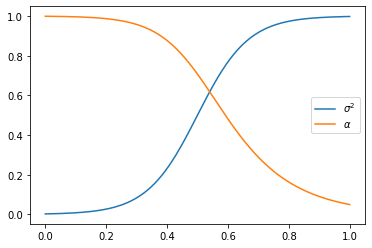

In [293]:
ts = np.linspace(0, 1, 1000)
plt.plot(ts, sigma2(gamma(ts)), label=r'$\sigma^2$')
plt.plot(ts, alpha(gamma(ts)), label=r'$\alpha$')
plt.legend();

In [294]:
def variance_preserving_map(x, gamma, eps):
    a = alpha(gamma)
    var = sigma2(gamma)

    x_shape = x.shape

    x = x.reshape(x.shape[0], -1)
    eps = eps.reshape(eps.shape[0], -1)

    noise_augmented = a * x + np.sqrt(var) * eps

    return noise_augmented.reshape(x_shape)

In [295]:
def get_timestep_embedding(timesteps, embedding_dim: int, dtype=np.float32):
  """Build sinusoidal embeddings (from Fairseq)."""

  assert len(timesteps.shape) == 1
  timesteps *= 1000

  half_dim = embedding_dim // 2
  emb = np.log(10_000) / (half_dim - 1)
  emb = np.exp(np.arange(half_dim, dtype=dtype) * -emb)
  emb = timesteps.astype(dtype)[:, None] * emb[None, :]
  emb = np.concatenate([np.sin(emb), np.cos(emb)], axis=1)
  if embedding_dim %2 == 1: # zero pad
    emb = jax.lax.pad(emb, dtype(0), ((0, 0, 0), (0, 1, 0)))
  assert emb.shape == (timesteps.shape[0], embedding_dim)
  return emb

In [296]:
class ResNet(nn.Module):
  hidden_size: int
  n_layers: int = 1
  middle_size: int = 512

  @nn.compact
  def __call__(self, x, cond=None):
    assert x.shape[-1] == self.hidden_size, "Input must be hidden size."
    z = x
    for i in range(self.n_layers):
      h = nn.gelu(nn.LayerNorm()(z))
      h = nn.Dense(self.middle_size)(h)
      if cond is not None:
        h += nn.Dense(self.middle_size, use_bias=False)(cond[:, None, :])
      h = nn.gelu(nn.LayerNorm()(h))
      h = nn.Dense(self.hidden_size, kernel_init=jax.nn.initializers.zeros)(h)
      z = z + h 
    return z

In [297]:
realize = tfb.Shift(-1)(tfb.Scale(2)(tfb.Scale(1./256)(tfb.Shift(0.5))))

class Encoder(nn.Module):
  hidden_size: int = 256
  n_layers: int = 3
  z_dim: int = 128

  @nn.compact
  def __call__(self, ims, cond=None):
    # x = 2 * ims.astype('float32') - 1.0
    # x = einops.rearrange(x, '... x y d -> ... (x y d)')
    x = nn.Dense(self.hidden_size)(ims)
    x = ResNet(self.hidden_size, self.n_layers)(x, cond=cond)
    params = nn.Dense(self.z_dim)(ims)
    # params = ims
    return params
    

In [550]:
import jax.numpy as jnp

class Decoder(nn.Module):
  hidden_size: int = 512
  n_layers: int = 3

  @nn.compact
  def __call__(self, z, cond=None, std=0.001):
    z = nn.Dense(self.hidden_size)(z)
    z = ResNet(self.hidden_size, self.n_layers)(z, cond=cond)
    logits = nn.Dense(3)(z)
    # logits = z
    # logits = einops.rearrange(logits, '... (x y d) -> ... x y d', x=28, y=28, d=1)
    # return tfd.Independent(tfd.Bernoulli(logits=logits), 3)
    log_std = self.param('log_std', nn.initializers.constant(np.log(0.0001)), (1,))
    return tfd.Normal(loc=logits, scale=np.exp(log_std))
    # return tfd.Normal(loc=logits, scale=0.001)

In [551]:
import sys
sys.path.append("../")
from models.transformer import Transformer

class ScoreNet(nn.Module):
  embedding_dim: int = 128
  n_layers: int = 10

  @nn.compact
  def __call__(self, z, g_t, conditioning):
    n_embd = self.embedding_dim

    t = g_t
    assert np.isscalar(t) or len(t.shape) == 0 or len(t.shape) == 1
    t = t * np.ones(z.shape[0])  # ensure t is a vector
    temb = get_timestep_embedding(t, 16)
    cond = np.concatenate([temb, conditioning], axis=1)
    # cond = np.concatenate([t[:, None], conditioning], axis=1)
    cond = nn.gelu(nn.Dense(features=n_embd * 4, name='dense0')(cond))
    cond = nn.gelu(nn.Dense(features=n_embd * 4, name='dense1')(cond))
    cond = nn.Dense(n_embd)(cond)

    h = nn.Dense(n_embd)(z)
    # h = jax.vmap(ResNet(n_embd, self.n_layers))(h, cond)

    h = jax.vmap(Transformer(n_input=n_embd))(h, cond)
    # h = jax.vmap(Transformer(n_input=n_embd))(h[:, None, :], cond[:, :])
    # h = h[:, 0, :]

    return z + h


In [552]:
class NoiseSchedule_Scalar(nn.Module):
  gamma_min: float = -6.
  gamma_max: float = 6.

  def setup(self):
    init_bias = self.gamma_max
    init_scale = self.gamma_min - self.gamma_max
    self.w = self.param('w', nn.initializers.constant(init_scale), (1,))
    self.b = self.param('b', nn.initializers.constant(init_bias), (1,))

  @nn.compact
  def __call__(self, t):
    return self.b + -abs(self.w) * t

class NoiseSchedule_FixedLinear(nn.Module):
  gamma_min: float = -6.
  gamma_max: float = 6.

  @nn.compact
  def __call__(self, t):
    return self.gamma_max + (self.gamma_min-self.gamma_max) * t

In [553]:
gamma(ts)

DeviceArray([ 6.       ,  4.6666665,  3.3333333,  2.       ,  0.6666665,
             -0.666667 , -2.       , -3.333334 , -4.666667 , -6.       ],            dtype=float32)

In [554]:
ns = NoiseSchedule_Scalar()
ts = jnp.linspace(0., 1., 10)
ns.init_with_output(rng, ts)

(DeviceArray([ 6.       ,  4.6666665,  3.3333333,  2.       ,  0.6666665,
              -0.666667 , -2.       , -3.333334 , -4.666667 , -6.       ],            dtype=float32),
 FrozenDict({
     params: {
         w: DeviceArray([-12.], dtype=float32),
         b: DeviceArray([6.], dtype=float32),
     },
 }))

In [555]:
class VDM(nn.Module):
  timesteps: int = 1000
  gamma_min: float = -3.0 # -13.3
  gamma_max: float = 3.0  # 5.0
  embedding_dim: int = 256
  antithetic_time_sampling: bool = True
  layers: int = 32

  def setup(self):
    # self.gamma = partial(gamma, gamma_min=self.gamma_min, gamma_max=self.gamma_max)
    # self.gamma = NoiseSchedule_FixedLinear(gamma_min=self.gamma_min, gamma_max=self.gamma_max)
    self.gamma = NoiseSchedule_Scalar(gamma_min=self.gamma_min, gamma_max=self.gamma_max)
    self.score_model = ScoreNet(n_layers=self.layers,
                                embedding_dim=self.embedding_dim)
    self.encoder = Encoder(z_dim=self.embedding_dim)
    self.decoder = Decoder()

  def gammat(self, t):
    return self.gamma(t)

  def recon_loss(self, x, f, cond):
    """The reconstruction loss measures the gap in the first step.

    We measure the gap from encoding the image to z_0 and back again."""
    # ## Reconsturction loss 2
    g_0 = self.gamma(0.0)
    eps_0 = random.normal(self.make_rng("sample"), shape=f.shape)
    z_0 = variance_preserving_map(f, g_0, eps_0)
    z_0_rescaled = z_0 / alpha(g_0)
    loss_recon = -self.decoder(z_0_rescaled, cond, jnp.sqrt(sigma2(gamma(0.)))).log_prob(x)
    return loss_recon

  def latent_loss(self, f):
    """The latent loss measures the gap in the last step, this is the KL
    divergence between the final sample from the forward process and starting 
    distribution for the reverse process, here taken to be a N(0,1)."""
    # KL z1 with N(0,1) prior
    g_1 = self.gamma(1.0)
    var_1 = sigma2(g_1)
    mean1_sqr = (1. - var_1) * np.square(f)
    loss_klz = 0.5 * np.sum(mean1_sqr + var_1 - np.log(var_1) - 1., axis=(-1, -2))
    return loss_klz

  def diffusion_loss(self, t, f, cond):
    # sample z_t
    g_t = self.gamma(t)
    eps = jax.random.normal(self.make_rng("sample"), shape=f.shape)
    z_t = variance_preserving_map(f, g_t[:, None], eps)
    # compute predicted noise
    eps_hat = self.score_model(z_t, g_t, cond)
    # compute MSE of predicted noise
    loss_diff_mse = np.sum(np.square(eps - eps_hat), axis=(-1, -2))

    # loss for finite depth T, i.e. discrete time
    T = self.timesteps
    s = t - (1./T)
    g_s = self.gamma(s)
    loss_diff = .5 * T * np.expm1(g_s - g_t) * loss_diff_mse
    return loss_diff

  def __call__(self, images, conditioning,
               sample_shape=()):

    x = images
    n_batch = images.shape[0]

    cond = conditioning

    # 1. RECONSTRUCTION LOSS
    # add noise and reconstruct
    f = self.encoder(x, cond)
    loss_recon = self.recon_loss(x, f, cond)
    
    # 2. LATENT LOSS
    # KL z1 with N(0,1) prior
    loss_klz = self.latent_loss(f)

    # 3. DIFFUSION LOSS
    # sample time steps
    rng1 = self.make_rng("sample")
    if self.antithetic_time_sampling:
      t0 = jax.random.uniform(rng1)
      t = np.mod(t0 + np.arange(0., 1., step=1. / n_batch), 1.0)
    else:
      t = jax.random.uniform(rng1, shape=(n_batch,))

    # discretize time steps if we're working with discrete time
    T = self.timesteps
    t = np.ceil(t * T) / T

    loss_diff = self.diffusion_loss(t, f, cond)

    # End of diffusion loss computation
    return (loss_diff, loss_klz, loss_recon)

  def embed(self, conditioning):
    return conditioning

  def encode(self, ims, conditioning=None):
    cond = conditioning
    return self.encoder(ims, cond)
    # return ims

  def decode(self, z0, conditioning=None):
    cond = conditioning
    return self.decoder(z0, cond, sigma2(gamma(0.)))
    # return z0

  def sample_step(self, rng, i, T, z_t, conditioning, guidance_weight=0.):
    rng_body = jax.random.fold_in(rng, i)
    eps = random.normal(rng_body, z_t.shape)
    t = (T - i)/T 
    s = (T - i - 1) / T

    g_s = self.gamma(s)
    g_t = self.gamma(t)

    cond = conditioning

    eps_hat_cond = self.score_model(
        z_t,
        g_t * np.ones((z_t.shape[0],), z_t.dtype),
        cond,)
  
    eps_hat_uncond = self.score_model(
        z_t,
        g_t * np.ones((z_t.shape[0],), z_t.dtype),
        cond * 0.,)
    eps_hat = (1. + guidance_weight) * eps_hat_cond - guidance_weight * eps_hat_uncond
    
    
    a = nn.sigmoid(g_s)
    b = nn.sigmoid(g_t)
    c = -np.expm1(g_t - g_s)
    sigma_t = np.sqrt(sigma2(g_t))
    z_s = np.sqrt(a / b) * (z_t - sigma_t * c * eps_hat) + np.sqrt((1. - a) * c) * eps
    
    return z_s


  def recon(self, z, t, conditioning):
    g_t = self.gamma(t)[:, None]
    cond = conditioning
    eps_hat = self.score_model(z, g_t, cond)
    sigmat = np.sqrt(sigma2(g_t))
    alphat = np.sqrt(1 - sigmat**2)
    xhat = (z - sigmat * eps_hat ) / alphat
    return (eps_hat, xhat)




In [556]:
def generate(vdm, params, rng, shape, conditioning, guidance_weight=0.0):
  # first generate latent
  rng, spl = random.split(rng)
  zt = random.normal(spl, shape + (vdm.embedding_dim,))

  def body_fn(i, z_t):
    return vdm.apply(
        params,
        rng,
        i,
        vdm.timesteps,
        z_t,
        conditioning,
        guidance_weight=guidance_weight,
        method=vdm.sample_step)
  
  z0 = jax.lax.fori_loop(
      lower=0, upper=vdm.timesteps, body_fun=body_fn, init_val=zt)
  g0 = vdm.apply(params, 0.0, method=vdm.gammat)
  var0 = sigma2(g0)
  z0_rescaled = z0 / np.sqrt(1. - var0)
  return vdm.apply(params, z0_rescaled, conditioning, method=vdm.decode)


def recon(vdm, params, rng, t, ims, conditioning):
  # first generate latent
  rng, spl = random.split(rng)
  z_0 = vdm.apply(params, ims, conditioning, method=vdm.encode)

  T = vdm.timesteps
  tn = np.ceil(t * T)
  t = tn / T
  g_t = vdm.apply(params, t, method=vdm.gammat)
  rng, spl = random.split(rng)
  eps = jax.random.normal(spl, shape=z_0.shape)
  z_t = variance_preserving_map(z_0, g_t[:,None], eps)

  def body_fn(i, z_t):
    return vdm.apply(
        params,
        rng,
        i,
        vdm.timesteps,
        z_t,
        conditioning,
        method=vdm.sample_step)
  
  z0 = jax.lax.fori_loop(
      lower=(T - tn).astype('int'), 
      upper=vdm.timesteps, body_fun=body_fn, init_val=z_t)
  g0 = vdm.apply(params, 0.0, method=vdm.gammat)
  var0 = sigma2(g0)
  z0_rescaled = z0 / np.sqrt(1. - var0)
  return vdm.apply(params, z0_rescaled, conditioning, method=vdm.decode)

(-2.0, 2.0)

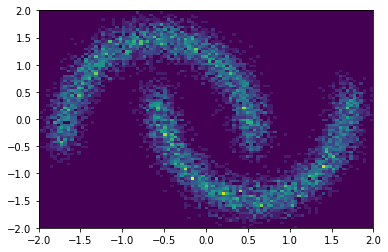

In [557]:
from sklearn import datasets, preprocessing

n_samples = 10_000

x, _ = datasets.make_moons(n_samples=n_samples, noise=.1)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

In [558]:
from jetnet.datasets import JetNet, TopTagging

num_particles = 30

particle_data, jet_data = JetNet.getData(jet_type=["q"], data_dir="../data/", num_particles=num_particles)

idx_full = np.where(particle_data[..., 3].sum(-1) == num_particles)

jet_data_mean = jet_data.mean(axis=(0,))
jet_data_std = jet_data.std(axis=(0,))
jet_data = (jet_data - jet_data_mean + 1e-7) / (jet_data_std + 1e-7)

particle_data = particle_data[idx_full] # + jax.random.normal(key=rng, shape=particle_data[idx_full].shape) * 0.001
particle_data = particle_data[:, :, :3]

jet_data = jet_data[idx_full]

In [559]:
rng = jax.random.PRNGKey(42)

In [560]:
# import pandas as pd

# num_particles = 100
# particle_data = np.load("/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/positions.npy")
# particle_data_mean = particle_data.mean(axis=(0,))
# particle_data_std = particle_data.std(axis=(0,))
# particle_data = (particle_data - particle_data_mean + 1e-7) / (particle_data_std + 1e-7)

# # subsample_idxs = jax.random.choice(key=rng, a=particle_data.shape[1], shape=(particle_data.shape[0], num_particles), replace=True, axis=1)
# particle_data = particle_data[:, :num_particles, :]

# jet_data = np.zeros((particle_data.shape[0], 1))

# jet_data = np.array(pd.read_csv("/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/cosmology.csv").values)

In [561]:
batch_size = 128 * jax.device_count()
n_train = len(particle_data)

# jet_data = np.zeros((particle_data.shape[0], 1))

train_ds = tf.data.Dataset.from_tensor_slices((particle_data, jet_data))
train_ds = train_ds.cache()
train_ds = train_ds.repeat()

batch_dims=[jax.local_device_count(), batch_size // jax.device_count()]

for batch_size in reversed(batch_dims):
      train_ds = train_ds.batch(batch_size, drop_remainder=False)

train_ds = train_ds.shuffle(n_train)
train_df = create_input_iter(train_ds)

In [562]:
batch = np.array(particle_data[:2])
conditioning = np.zeros((2, jet_data.shape[-1]))

In [563]:
vdm = VDM(gamma_min=-6.0, 
          gamma_max=6.0, 
          layers=4, 
          embedding_dim=6,
          timesteps=500)

rng = random.PRNGKey(0)

In [564]:
out, params = vdm.init_with_output({"sample": rng, "params": rng}, batch, conditioning);

In [565]:
print(f"Params: {param_count(params):,}")

Params: 7,142,476


<ipython-input-3-3628026ce675>:11: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  return sum(x.size for x in jax.tree_leaves(pytree))


In [566]:
def loss(params, rng, im, lb, beta=1.0):
  l1, l2, l3 = vdm.apply(params, im.astype('float'), lb, rngs={"sample": rng})
  rescale_to_bpd = 1./(onp.prod(im.shape[1:]) * np.log(2.0))
  return (l1.mean()/beta + l2.mean()/beta + l3.mean()) * rescale_to_bpd

loss(params, rng, batch, conditioning)

<ipython-input-566-e5592c06c9bf>:2: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  l1, l2, l3 = vdm.apply(params, im.astype('float'), lb, rngs={"sample": rng})


DeviceArray(5337.943, dtype=float32)

In [567]:
from typing import Any

@flax.struct.dataclass
class Store:
  params: np.ndarray
  state: Any
  rng: Any
  step: int = 0


TSTEPS = 20_000 // jax.device_count()

# we'll use adamw with some linear warmup and a cosine decay.
opt = optax.chain(
    optax.scale_by_schedule(optax.cosine_decay_schedule(1.0, TSTEPS, 1e-5)),
    optax.adamw(8e-4, b1=0.9, b2=0.99, eps=1e-8, weight_decay=1e-4),
    optax.scale_by_schedule(
        optax.linear_schedule(0.0, 1.0, 1000)))

store = Store(params, opt.init(params), rng, 0)
pstore = replicate(store)

We'll make a simple step function that we can pmap to make better use of our accelerators.

In [568]:
import functools

@functools.partial(jax.pmap, axis_name='batch')
def step(store, batch):
  rng, spl = random.split(store.rng)
  im, lb = batch
  out, grads = jax.value_and_grad(loss)(store.params, spl, im, lb)
  grads = jax.lax.pmean(grads, 'batch')
  updates, state = opt.update(grads, store.state, store.params)
  params = optax.apply_updates(store.params, updates)

  return (store.replace( 
      params=params,
      state=state,
      rng=rng,
      step=store.step + 1),  
      jax.lax.pmean(out, 'batch'))

In [569]:
vals = []

Our actual training, with the standard configuration in this colab, and using a GPU as an accelerator this should take about ~30 minutes on a T4.

In [570]:
batches = create_input_iter(train_ds)
# ebatches = create_input_iter(test_ds)

with trange(TSTEPS) as t:
  for i in t:
    pstore, val = step(pstore, next(batches))
    v = unreplicate(val)
    t.set_postfix(val=v)
    vals.append(v)

  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-566-e5592c06c9bf>:2: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  l1, l2, l3 = vdm.apply(params, im.astype('float'), lb, rngs={"sample": rng})
100%|██████████| 5000/5000 [06:23<00:00, 13.03it/s, val=2.57979]    


our loss went down nicely over time.

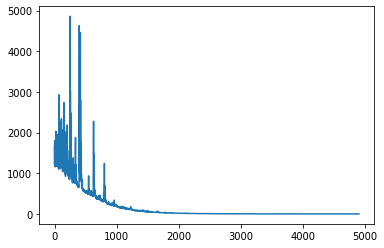

In [572]:
plt.plot(vals[100:])

In [573]:
# n_samples = 100
# x_samples = generate(vdm, unreplicate(pstore).params, rng, (n_samples, num_particles), jet_data[:n_samples])
# x_samples = x_samples.mean()
# plt.scatter(x_samples[0, :, 0], x_samples[0, :, 1]);

In [574]:
# plt.scatter(particle_data[0, :, 0], particle_data[0, :, 1]);

In [575]:
n_samples = 1000
cond = jet_data[:n_samples]
# cond = np.zeros_like(cond)
x_samples = generate(vdm, unreplicate(pstore).params, rng, (n_samples, 30), cond, guidance_weight=0.)
x_samples = x_samples.mean()

100%|██████████| 16/16 [00:00<00:00, 48.95it/s]


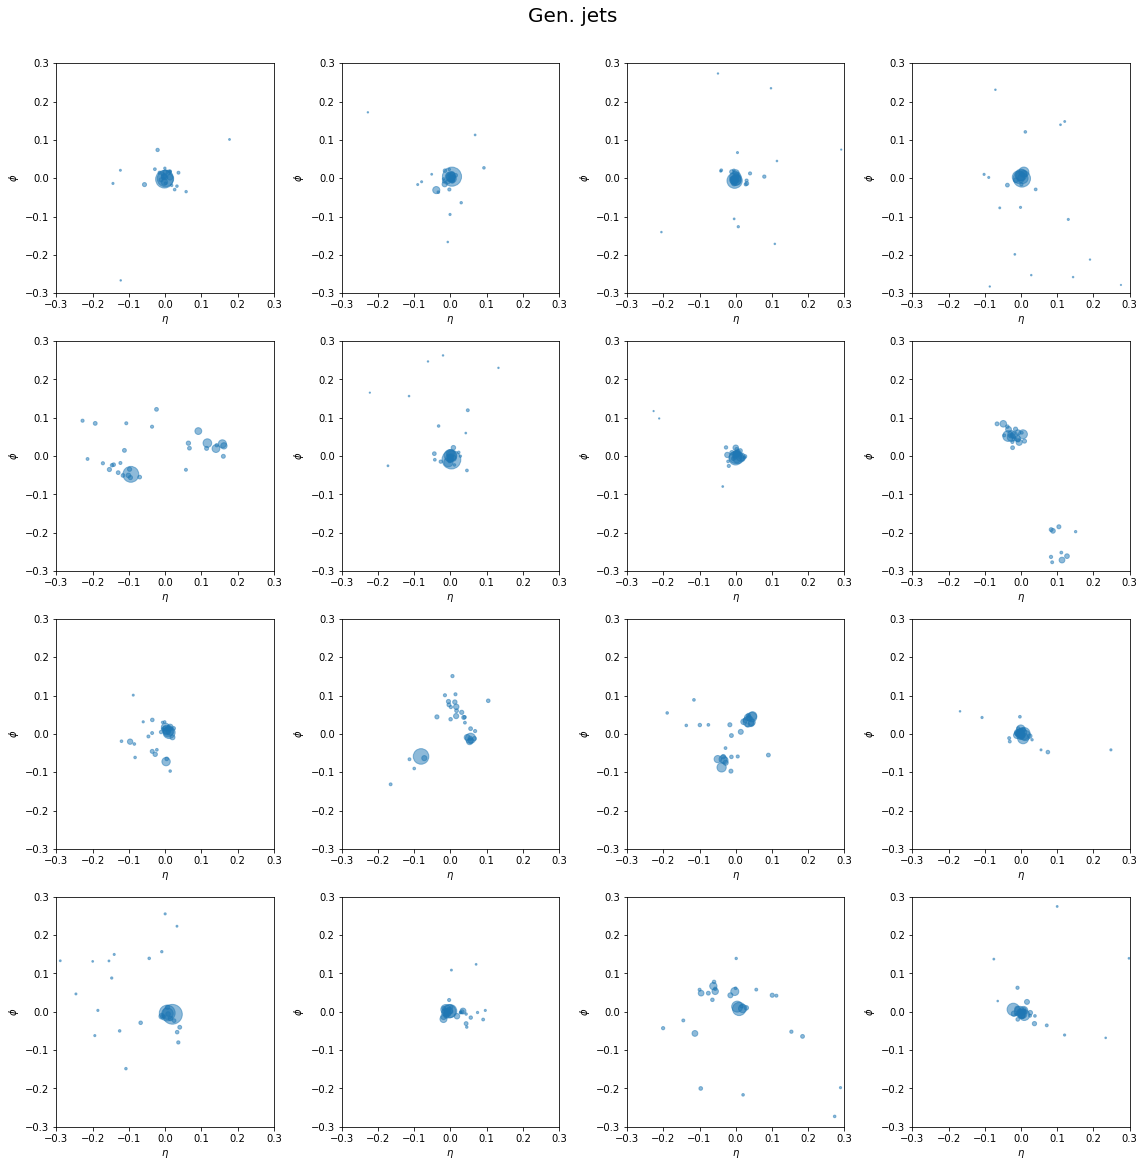

In [576]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16, 16))
gs = GridSpec(4, 4)

for i in tqdm(range(16)):
    
    ax = fig.add_subplot(gs[i])
    
    ax.scatter(*x_samples[i, :, :2].T, s=1000 * (x_samples[i, :, 2]), alpha=0.5)  # Hacky np.abs!!
            
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Gen. jets", fontsize=20, y=1.01)
plt.tight_layout()

In [577]:
unreplicate(pstore).params['params']['gamma']

FrozenDict({
    b: DeviceArray([7.5170703], dtype=float32),
    w: DeviceArray([-12.021134], dtype=float32),
})

In [578]:
np.exp(unreplicate(pstore).params['params']['decoder']['log_std'])

DeviceArray([0.00100331], dtype=float32)

In [579]:
x = particle_data[:1000]

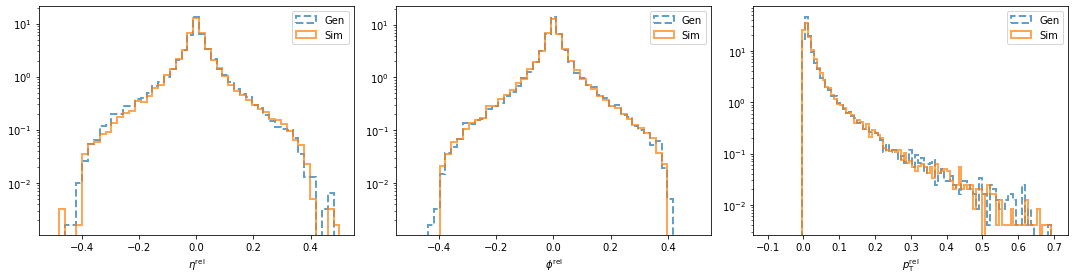

In [580]:
fig = plt.figure(figsize=(20, 4))
gs = GridSpec(1, 4)

#####

ax = fig.add_subplot(gs[0])

i_feat = 0

bins= np.linspace(-0.5, 0.5, 50)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen');

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim');

ax.set_xlabel(r"$\eta^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])

ax.set_yscale("log")

ax.legend()

#####

ax = fig.add_subplot(gs[1])

i_feat = 1

bins= np.linspace(-0.5, 0.5, 50)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen');

eta = (np.concatenate(np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim');

ax.set_xlabel(r"$\phi^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])

ax.set_yscale("log")

ax.legend()

#####

ax = fig.add_subplot(gs[2])

i_feat = 2

bins= np.linspace(-0.1, 0.7, 100)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen');

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim');

ax.set_xlabel(r"$p_\mathrm{T}^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])
ax.legend()

ax.set_yscale("log")

ax.legend()

plt.tight_layout()

In [582]:
x_samples[:, :, -1]

DeviceArray([[0.02264563, 0.00580691, 0.00711362, ..., 0.04180313,
              0.02555797, 0.00606894],
             [0.00350925, 0.06137155, 0.0124324 , ..., 0.01297783,
              0.04502828, 0.00610255],
             [0.01822956, 0.00443516, 0.01094334, ..., 0.00278525,
              0.00160824, 0.00618585],
             ...,
             [0.02258317, 0.01441028, 0.00474187, ..., 0.0084945 ,
              0.00710298, 0.01587043],
             [0.07040606, 0.01072644, 0.0356691 , ..., 0.02809951,
              0.00560794, 0.04624751],
             [0.01687111, 0.01741767, 0.00825683, ..., 0.00812231,
              0.03451373, 0.00482287]], dtype=float32)

In [111]:
L = 10
mask = np.log(np.tril(np.ones((L, L))))
mask

DeviceArray([[  0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
             [  0.,   0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
             [  0.,   0.,   0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
             [  0.,   0.,   0.,   0., -inf, -inf, -inf, -inf, -inf, -inf],
             [  0.,   0.,   0.,   0.,   0., -inf, -inf, -inf, -inf, -inf],
             [  0.,   0.,   0.,   0.,   0.,   0., -inf, -inf, -inf, -inf],
             [  0.,   0.,   0.,   0.,   0.,   0.,   0., -inf, -inf, -inf],
             [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -inf, -inf],
             [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -inf],
             [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]],            dtype=float32)

In [112]:
mask = np.ones((L, L))
mask = mask.at[:, 5:].set(0.)
np.log(mask)

DeviceArray([[  0.,   0.,   0.,   0.,   0., -inf, -inf, -inf, -inf, -inf],
             [  0.,   0.,   0.,   0.,   0., -inf, -inf, -inf, -inf, -inf],
             [  0.,   0.,   0.,   0.,   0., -inf, -inf, -inf, -inf, -inf],
             [  0.,   0.,   0.,   0.,   0., -inf, -inf, -inf, -inf, -inf],
             [  0.,   0.,   0.,   0.,   0., -inf, -inf, -inf, -inf, -inf],
             [  0.,   0.,   0.,   0.,   0., -inf, -inf, -inf, -inf, -inf],
             [  0.,   0.,   0.,   0.,   0., -inf, -inf, -inf, -inf, -inf],
             [  0.,   0.,   0.,   0.,   0., -inf, -inf, -inf, -inf, -inf],
             [  0.,   0.,   0.,   0.,   0., -inf, -inf, -inf, -inf, -inf],
             [  0.,   0.,   0.,   0.,   0., -inf, -inf, -inf, -inf, -inf]],            dtype=float32)